In [16]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score

## Define functions

In [2]:
def calc_rmsd(x,y):
    d = (x-y)**2
    rmsd = np.sqrt(np.nanmean(d))
    return rmsd

def rmsd_to_matrices(prot):
    """
    Loop over residues in protein and calculate RMSD_exposed and RMSD_buried 
    for all residues using substitution matrices constructed using only
    monomer structure data and omitting data from the protein being analysed. 
    """
    # get sequences
    sequence_dict = pd.read_pickle("../data/sequences.pkl")
    sequence = sequence_dict[prot]

    # get vampseq data
    vampseq_data = pd.read_csv("../data/vampseq_data/processed/vampseq_soluble_df.csv")
    vampseq_prot_df = vampseq_data.groupby("prot").get_group(prot)

    # initialise arrays
    rmsd_b_arr = np.zeros(len(sequence))
    rmsd_b_arr[:] = np.nan

    rmsd_e_arr = np.zeros(len(sequence))
    rmsd_e_arr[:] = np.nan

    # read monomer-based matrices
    buried_matrix = pd.read_pickle(f"../output/substitution_matrices/monomers/buried/leave_out_{prot}/mean.pkl")
    exposed_matrix = pd.read_pickle(f"../output/substitution_matrices/monomers/exposed/leave_out_{prot}/mean.pkl")

    # loop over all residues in sequence
    for resi in range(1,len(sequence)+1):

        if resi in np.unique(vampseq_prot_df.resi.values):

            # group dataframe by residue number
            vampseq_resi_df = vampseq_prot_df.groupby("resi").get_group(resi)

            if len(vampseq_resi_df) >= 5: # filter away positions with few scores
            
                # determine aa_ref 
                aa_ref = np.unique(vampseq_resi_df.aa_ref.values)[0]

                # get variant residue and abundance score arrays
                aa_var_arr = vampseq_resi_df.aa_var.values
                abundance_score_arr = vampseq_resi_df.abundance_score.values

                # get average scores from matrices
                buried_matrix_scores = buried_matrix.loc[aa_ref][aa_var_arr] 
                exposed_matrix_scores = exposed_matrix.loc[aa_ref][aa_var_arr]

                rmsd_b = calc_rmsd(buried_matrix_scores.values,abundance_score_arr)
                rmsd_b_arr[resi - 1] = rmsd_b

                rmsd_e = calc_rmsd(exposed_matrix_scores.values,abundance_score_arr)
                rmsd_e_arr[resi - 1] = rmsd_e
            
    return rmsd_b_arr, rmsd_e_arr


def get_structure_class():
    """
    Set structure class to either buried (0) or exposed (1)
    for all residues given their rASA in the WT protein structures. 
    """
    # read struc feature dataframe
    struc_feat_df = pd.read_csv("../output/structure_features/structure_features_monomers_AF.csv")

    # create new column
    struc_feat_df["struc_class"] = np.nan

    # find buried and set their class
    buried_arr_all = struc_feat_df['rASA'].values <= 0.1
    struc_feat_df["struc_class"][buried_arr_all] = 0

    # find exposed and set their class
    exposed_arr_all = struc_feat_df['rASA'].values > 0.1
    struc_feat_df["struc_class"][exposed_arr_all] = 1
    
    return struc_feat_df


def pred_structure_class():
    """
    Calculate RMSD_exposed and RMSD_buried for all residues and 
    use difference in the values to set the predicted structural 
    class to buried or exposed for each residue. 
    """
    sequence_dict = pd.read_pickle("../data/sequences.pkl")

    pred_class_df_list = []

    for prot in ['PTEN','TPMT','CYP2C9','NUDT15','ASPA','PRKN']:

        sequence = sequence_dict[prot]
        sequence_length = len(sequence)

        rmsd_b_arr, rmsd_e_arr = rmsd_to_matrices(prot)

        pred_struc_class_arr = np.zeros(sequence_length)
        pred_struc_class_arr[:] = np.nan

        pred_buried_class = np.where(rmsd_b_arr < rmsd_e_arr)[0]
        pred_exposed_class = np.where(rmsd_b_arr > rmsd_e_arr)[0]

        pred_struc_class_arr[pred_buried_class] = 0
        pred_struc_class_arr[pred_exposed_class] = 1

        pred_class_df = pd.DataFrame()
        pred_class_df["residue_number"] = range(1,sequence_length+1)
        pred_class_df["rmsd_b"] = rmsd_b_arr
        pred_class_df["rmsd_e"] = rmsd_e_arr
        pred_class_df["pred_struc_class"] = pred_struc_class_arr
        pred_class_df["prot"] = prot

        pred_class_df_list.append(pred_class_df)
        
    pred_class_df = pd.concat(pred_class_df_list)    
        
    return pred_class_df


def identify_interface_residues(protein):
    """
    Use difference in monomer and dimer structure rASA values to identify
    residues belonging to homodimer interface in crystal structures. 
    """
    # read dataframes with structural features
    struc_feat_monomer_df = pd.read_csv("../output/structure_features/structure_features_monomers_AF.csv")
    struc_feat_dimer_df = pd.read_csv("../output/structure_features/structure_features_AF.csv")
    
    # group by protein name
    monomer_df = struc_feat_monomer_df.groupby("prot").get_group(protein)
    dimer_df = struc_feat_dimer_df.groupby("prot").get_group(protein)
    
    assert np.all(monomer_df.residue_number.values == dimer_df.residue_number.values)
    
    # identify exposed residues in monomer
    monomer_exposed_resi = monomer_df[(monomer_df.rASA > 0.1) & (monomer_df.rASA > dimer_df.rASA + 0.01)].residue_number.values
    
    # identify buried residues in dimer
    dimer_buried_resi = dimer_df[dimer_df.rASA <= 0.1].residue_number.values
    
    # find intersection between the two arrays
    interface_resi = np.intersect1d(monomer_exposed_resi, dimer_buried_resi)
    
    return interface_resi


def plot_rmsd_with_average_abundance(protein, residue_number_arr, figsize, figname):
    """
    Given a list of residues, plot rmsd_b, rmsd_e and average abundance
    score for these residues.
    """
    c = sns.color_palette("Dark2")
    
    # read vampseq data and group by protein 
    vampseq_df = pd.read_csv("../data/vampseq_data/processed/vampseq_soluble_df.csv")
    vampseq_prot_df = vampseq_df.groupby("prot").get_group(protein)
    
    # calculate average abundance score per position
    vampseq_prot_df_mean = vampseq_prot_df.groupby("resi").mean()
    
    # update residue_number_arr to only contain residues with abundance scores
    residue_number_arr = residue_number_arr[np.isin(residue_number_arr,vampseq_prot_df_mean.index)]
    
    # get mean abundance scores and standard deviations for residues in residue_number_arr
    abundance_arr = vampseq_prot_df_mean.loc[residue_number_arr]["abundance_score"].values
    abundance_sd_arr = vampseq_prot_df.groupby("resi").std().loc[residue_number_arr]["abundance_score"].values
    
    # read dataframe with results from rmsd_b/rmsd_e analysis and group by protein
    struc_feat_df = pd.read_csv("../output/residue_class_analysis/struc_pred_feat_df.csv")
    struc_feat_prot_df = struc_feat_df.groupby("prot").get_group(protein)
    
    # get indices of residues in struc_feat_prot_df
    struc_feat_resi_idx = np.isin(struc_feat_prot_df.residue_number.values, residue_number_arr)
    
    # get rmsd_b and rmsd_e data
    rmsd_b_arr = struc_feat_prot_df[struc_feat_resi_idx]["rmsd_b"].values
    rmsd_e_arr = struc_feat_prot_df[struc_feat_resi_idx]["rmsd_e"].values
    
    # read sequences
    sequences_dict = pd.read_pickle("../data/sequences.pkl")
    sequence = sequences_dict[protein]
    
    # get aa_ref of residues in residue_number_arr to make xtick labels
    resi_aa_ref = np.array(list(sequence))[residue_number_arr - 1]
    xtick_labels = [j+str(i) for i,j in zip(residue_number_arr,resi_aa_ref)]
    
    # plot
    plt.rcParams['font.size'] = '15'
    fig, ax1 = plt.subplots(figsize=figsize)

    ax2 = ax1.twinx()

    lns1 = ax1.plot(range(len(residue_number_arr)), rmsd_e_arr, marker='o', markersize=6, 
             label=r"RMSD$_{exposed}$", color = c[0])
    lns2 = ax1.plot(range(len(residue_number_arr)), rmsd_b_arr, marker='o', markersize=6, 
             label=r"RMSD$_{buried}$", color = c[1])
    ax1.set_xticks(range(len(residue_number_arr)), xtick_labels, rotation=-45, fontsize=15)
    ax1.set_ylim(0.1,0.8)
    ax1.set_ylabel("RMSD")

    lns3 = ax2.errorbar(range(len(residue_number_arr)), y=abundance_arr, yerr=abundance_sd_arr, label="Abundance score",
                 marker='o', markersize=6, lw=1, color='dimgray', elinewidth=1.5, capsize=3, alpha=0.50)

    ax2.set_ylim(-0.1,1.15)
    ax2.set_ylabel("Average abundance score") 
    
    plt.title(protein)
    plt.tight_layout()
    plt.show()

## Run calculations and plot results

### Calculate RMSD_exposed and RMSD_buried for residues in all proteins

In [3]:
# set structure class (buried or exposed) based on residue rASA values in WT structures
struc_feat_df = get_structure_class()

# calculate rmsd_exposed and rmsd_buried for all residues and set predicted structure class
# to buried is rmsd_buried is smallest and to exposed if rmsd_exposed is smallest
pred_struc_feat_df = pred_structure_class()

# merge and save results
struc_feat_df = struc_feat_df.merge(pred_struc_feat_df,how="left",on=["prot","residue_number"])
struc_feat_df.to_csv("../output/residue_class_analysis/struc_pred_feat_df.csv",index=False)

/tmp/ipykernel_1996353/1617266642.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  struc_feat_df["struc_class"][buried_arr_all] = 0
/tmp/ipykernel_1996353/1617266642.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  struc_feat_df["struc_class"][exposed_arr_all] = 1


### Analyse crystal structure interface residues in NUDT15 and ASPA

In [5]:
# find interface residues in NUDT15 
interface_resi_nudt15 = identify_interface_residues("NUDT15")

# find interface residues in ASPA
interface_resi_aspa = identify_interface_residues("ASPA")

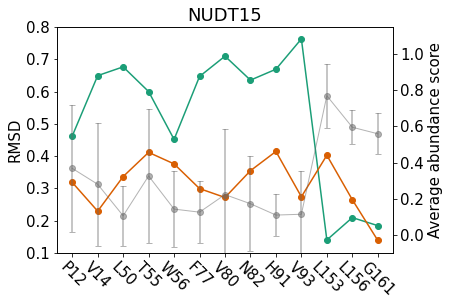

In [8]:
# plot NUDT15 results
plot_rmsd_with_average_abundance("NUDT15", interface_resi_nudt15, (6.5,4.5), "NUDT15_interface")

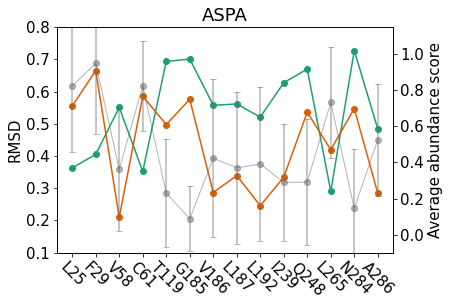

In [9]:
# plot ASPA results 
plot_rmsd_with_average_abundance("ASPA", interface_resi_aspa, (6.5,4.5), "ASPA_interface")

### Plot RMSD_exposed and RMSD_buried for all residues in all proteins

In [11]:
# set plot colors
sns.color_palette("colorblind")
c = sns.color_palette("colorblind")

In [12]:
# read struc_pred_feat dataframe
struc_feat_df = pd.read_csv("../output/residue_class_analysis/struc_pred_feat_df.csv")

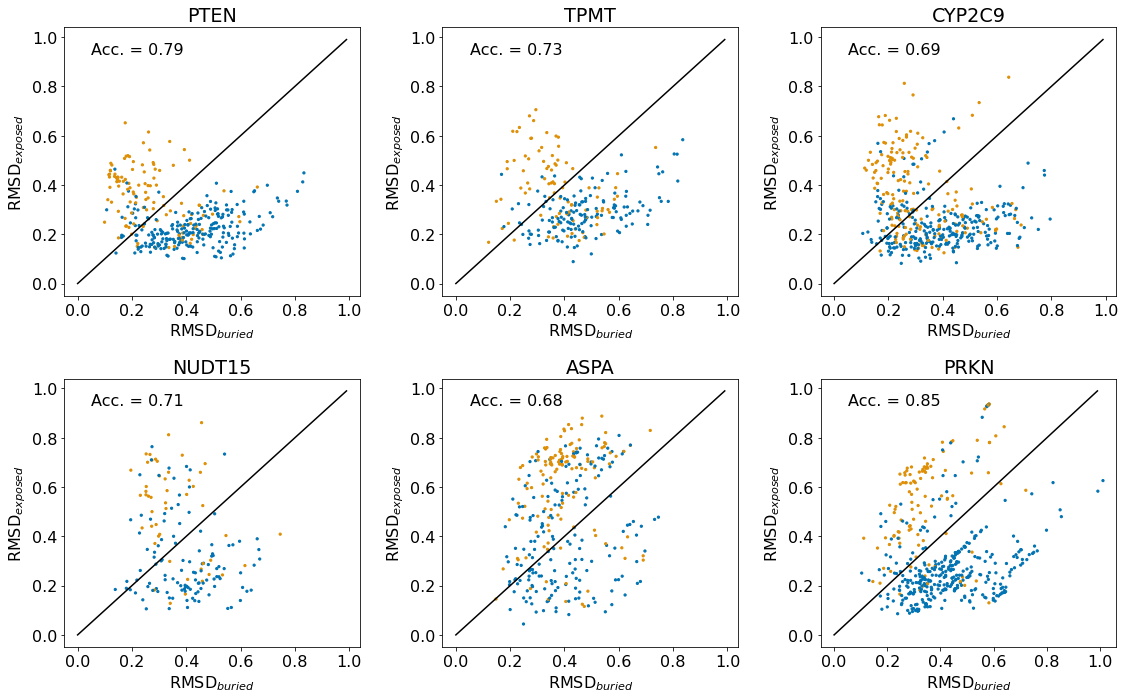

In [15]:
# plot 
color_dict = {-1:'silver', 0:c[1], 1:c[0]}
plt.rcParams.update({'font.size': 16})

# plot rmsd_e vs. rmsd_b    
plt.figure(figsize=(16,10)) 
i = 0

for prot in ['PTEN','TPMT','CYP2C9','NUDT15','ASPA','PRKN']:

    struc_feat_prot_df = struc_feat_df.groupby("prot").get_group(prot)
    struc_feat_prot_df = struc_feat_prot_df.dropna(subset=["pred_struc_class"])

    struc_class_arr = struc_feat_prot_df.struc_class.values
    pred_struc_class_arr = struc_feat_prot_df.pred_struc_class.values

    acc = balanced_accuracy_score(struc_class_arr,pred_struc_class_arr)
    acc = np.around(acc,2)
    
    i += 1
    plt.subplot(2,3,i)
    plt.scatter(struc_feat_prot_df["rmsd_b"],struc_feat_prot_df["rmsd_e"],
                c=[color_dict[i] for i in struc_feat_prot_df["struc_class"].values],
                s=5,label='Acc. = '+str(acc))
    
    plt.xlabel(r'RMSD$_{buried}$')
    plt.ylabel(r'RMSD$_{exposed}$')
    plt.title(prot)
    plt.legend(frameon=False,handlelength=0,markerscale=0)

    diag = np.arange(0,1,0.01)
    plt.plot(diag,diag,color='black')
    
plt.tight_layout()